In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

In [6]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [7]:
smiles = df['Standardized_SMILES'].values

In [8]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [9]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,N#Cc1ccc(Cn2cncc2CNC2CCN(C(=O)c3cccc(Cl)c3)C2)cc1,5.24,419.916,3.46078,0.663571,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,N=c1nc(N2CCC(N3CCCC3Cc3ccc(Cl)cc3)CC2)[nH][nH]1,5.40,360.893,2.54657,0.783948,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.44970,0.416926,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClC1C=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CC...,6.33,433.943,5.51330,0.417694,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NC(=O)c1ccccc1OC1CC2CCC(C1)N2Cc1ccccc1,6.47,336.435,3.35990,0.910738,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,O=C(CN=c1[nH]cnc2ccc(C(F)(F)F)cc12)NC1CN(C2CCC...,4.55,506.554,2.56970,0.493351,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,COc1ccc(CN2CCC(NC(=O)c3cc(=O)c4ccc(F)cc4o3)CC2...,8.27,410.445,3.33510,0.698647,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,CC(O)CN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[nH][nH]2...,5.03,378.908,1.76497,0.590116,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,COc1c(F)cccc1CC(c1ccccc1)N1CCNCC1,4.68,314.404,3.02330,0.917966,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
#Now incorporate this sort of noise into df during the training

In [11]:
X.shape

(1262, 20488)

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_cv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])

        y_train = np.delete(y.copy(), slice(start, stop + 1))
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("cv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.7515679799063049, pvalue=3.72487763996498e-24)
PearsonRResult(statistic=0.8633521152887076, pvalue=1.2096571726176386e-38)
PearsonRResult(statistic=0.8765155776961973, pvalue=3.4542204138388487e-41)
PearsonRResult(statistic=0.879125313272254, pvalue=9.984908037749111e-42)
PearsonRResult(statistic=0.8551520310959707, pvalue=3.4447006714612765e-37)
PearsonRResult(statistic=0.8779661736222018, pvalue=1.738891913835611e-41)
PearsonRResult(statistic=0.869572877053242, pvalue=8.218308906637936e-40)
PearsonRResult(statistic=0.8280758288885821, pvalue=5.878257422272115e-33)
PearsonRResult(statistic=0.8730345689248453, pvalue=4.086770128788121e-41)


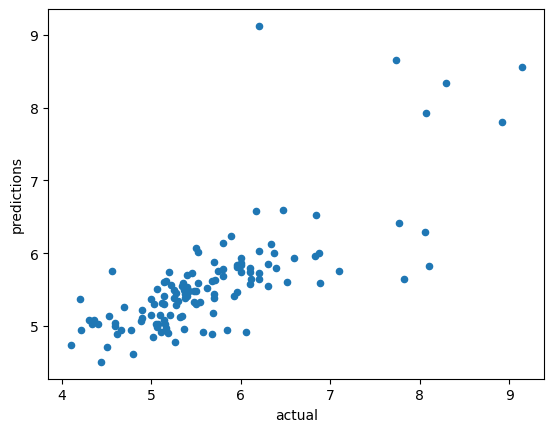

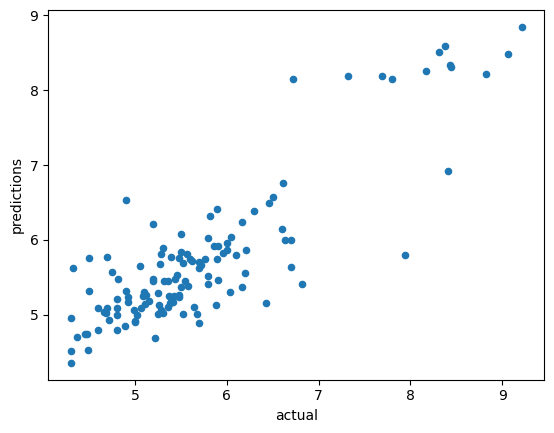

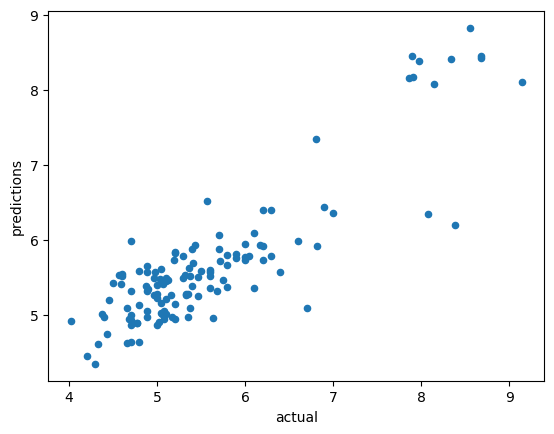

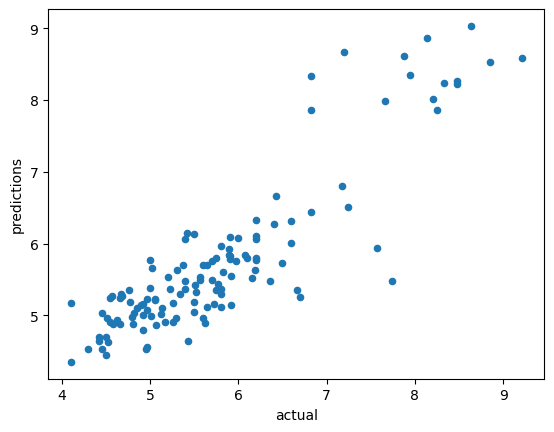

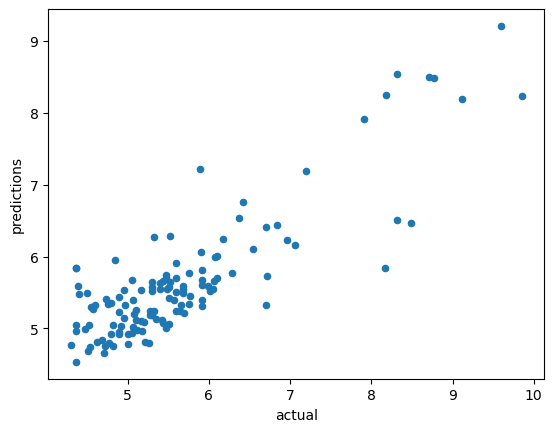

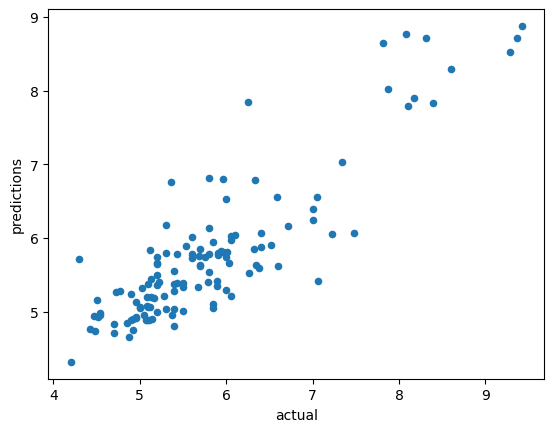

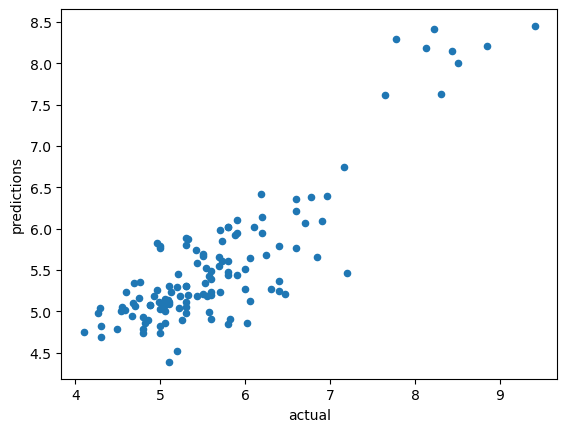

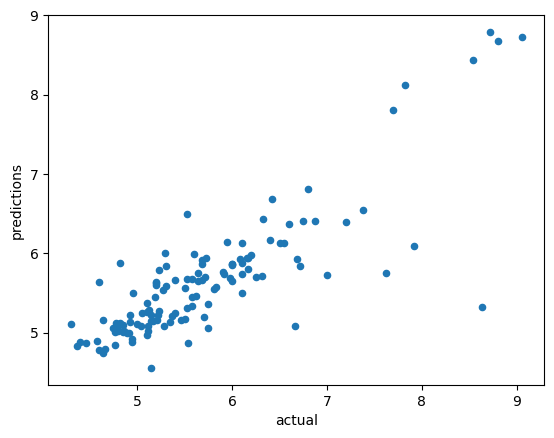

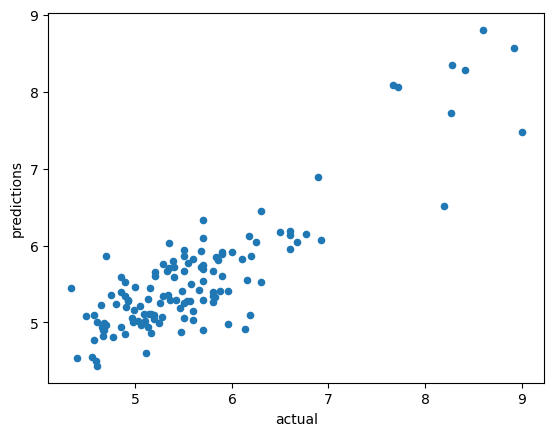

In [13]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_cv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [14]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(29, 3)
(25, 3)
(30, 3)
(32, 3)
(28, 3)
(30, 3)
(35, 3)
(33, 3)
(31, 3)


In [15]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(10, 3)
(14, 3)
(5, 3)
(12, 3)
(9, 3)
(7, 3)
(15, 3)
(9, 3)
(11, 3)


In [16]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(12, 3)
(14, 3)
(28, 3)
(12, 3)
(21, 3)
(9, 3)
(10, 3)
(10, 3)
(16, 3)


In [17]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(74, 3)
(70, 3)
(60, 3)
(69, 3)
(67, 3)
(74, 3)
(65, 3)
(71, 3)
(68, 3)


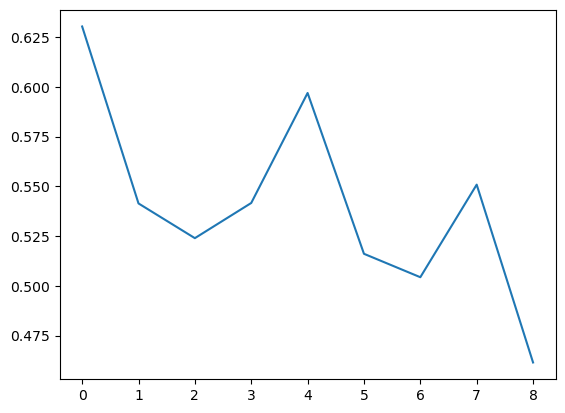

[0.6303803062248934, 0.5414178341273134, 0.5239637428386852, 0.5416497005401537, 0.5969471189788446, 0.516100752745166, 0.5043246837768967, 0.5508673221989726, 0.46146528377007956]


In [18]:
plt.plot(rmse)
plt.show()
print(rmse)

In [19]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

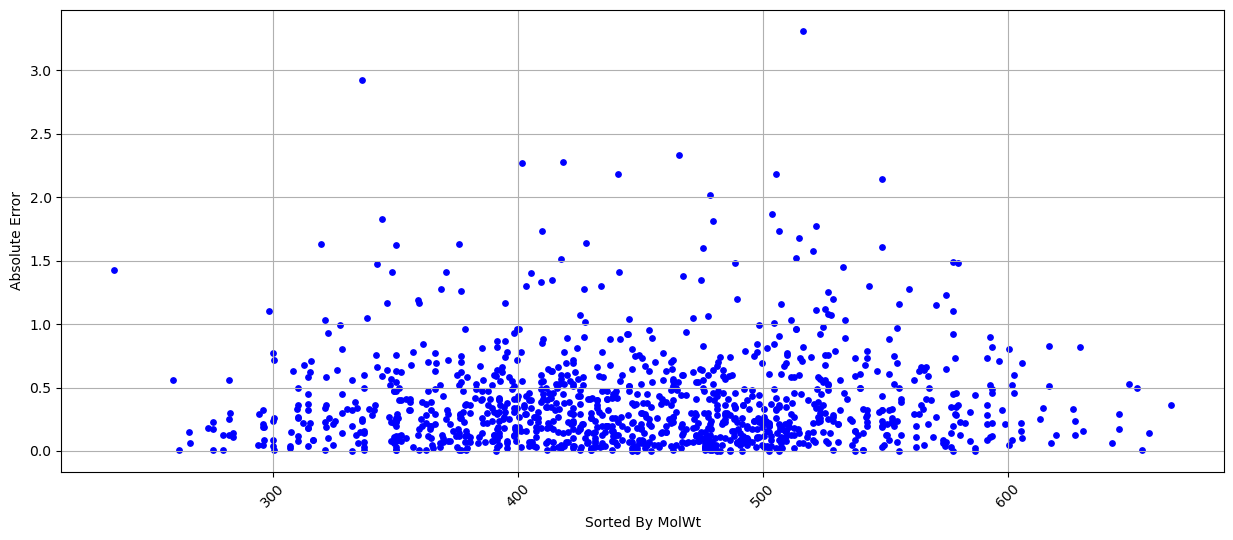

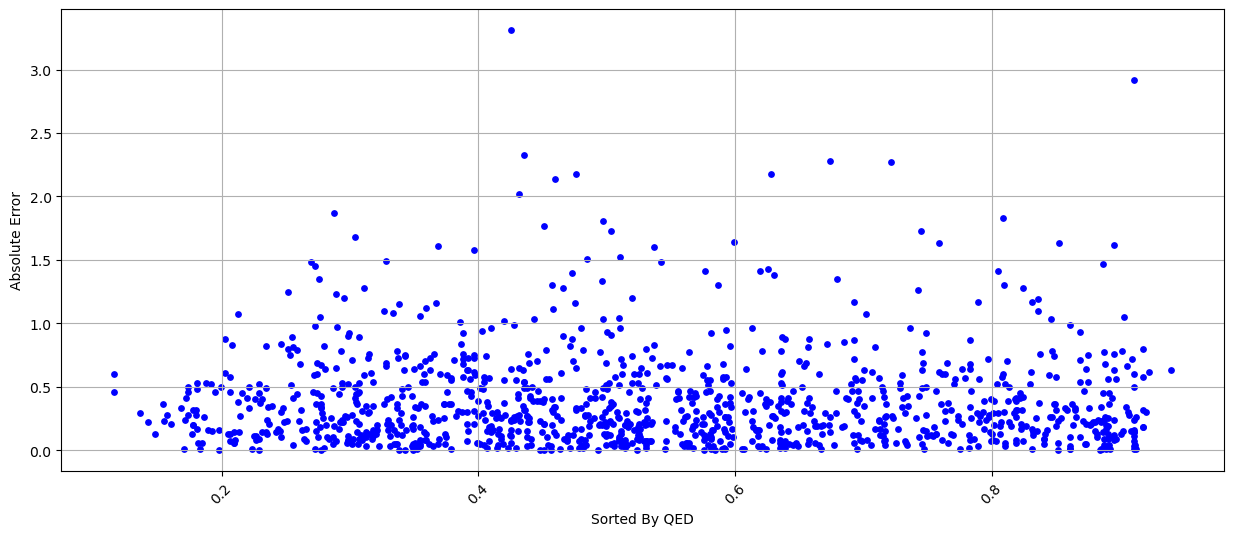

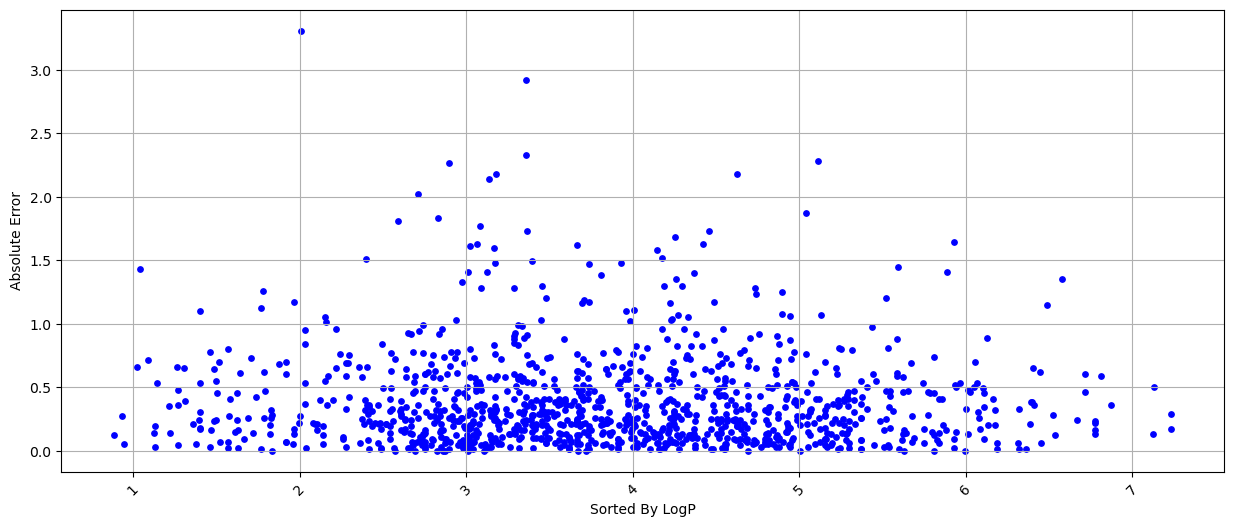

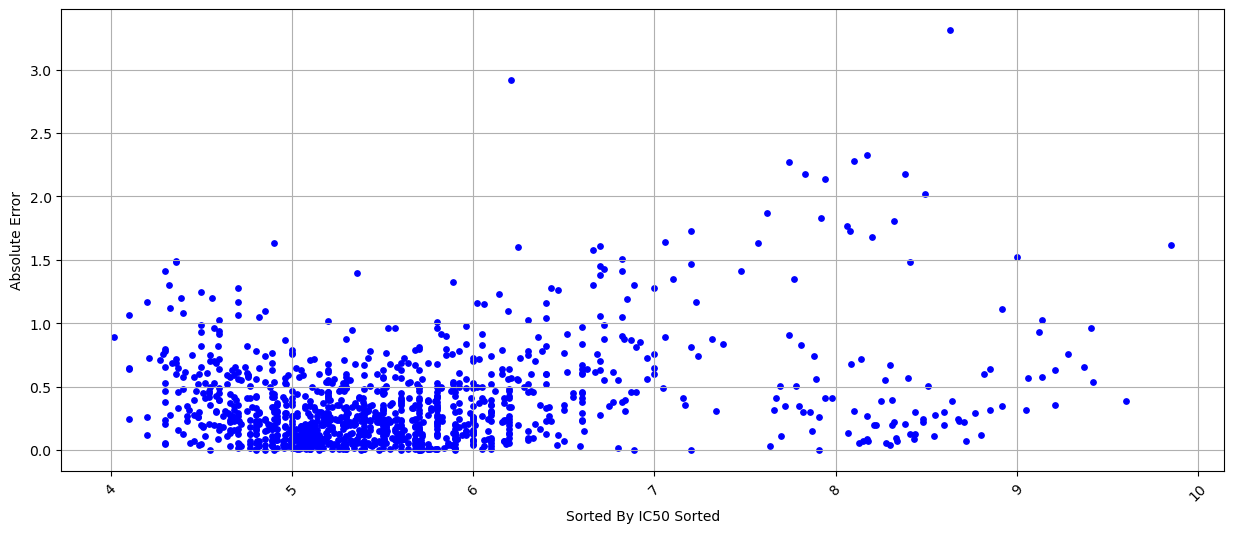

In [20]:
plot_graphs(df, results_df)

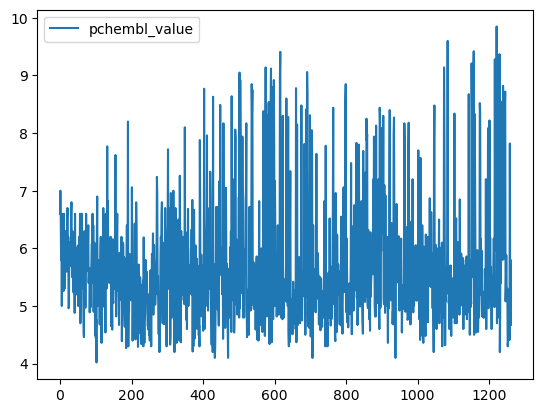

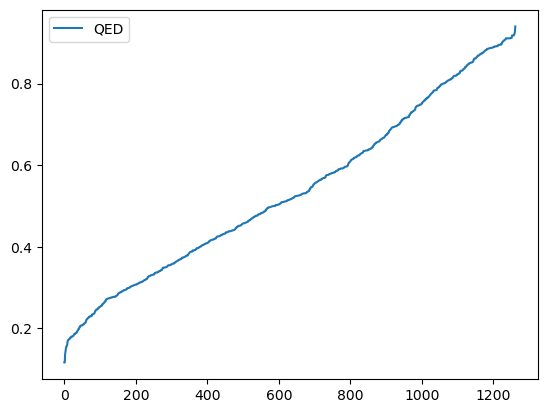

In [21]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [22]:
smiles1.shape

(1136,)

In [23]:
smiles_test.shape

(126,)

In [24]:
y_test.shape

(126,)

In [25]:
y1.shape

(1136,)

In [28]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_cv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train1 =np.vstack([X[:start]])
        X_train2=np.vstack([X[stop+1:]])
        X_train=np.vstack([X_train1,X_train2])
        
        y_train = np.delete(y.copy(), slice(start, stop + 1))
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all
                        })

    # Saving to CSV (optional)
    results_df.to_csv("cv_results_most_druglike.csv", index=False)


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.8339664258695871, pvalue=8.205803818654307e-34)
PearsonRResult(statistic=0.7873691596794429, pvalue=8.057473129484732e-28)
PearsonRResult(statistic=0.8035520236054345, pvalue=1.0204567673637263e-29)
PearsonRResult(statistic=0.7959698663312841, pvalue=8.299917771576857e-29)
PearsonRResult(statistic=0.8592795934486355, pvalue=6.554154640944342e-38)
PearsonRResult(statistic=0.832994388145737, pvalue=1.1416163972678284e-33)
PearsonRResult(statistic=0.8012601549752646, pvalue=1.9412647090423925e-29)
PearsonRResult(statistic=0.7602614925232178, pvalue=5.500954354228724e-25)
PearsonRResult(statistic=0.8134433097626144, pvalue=5.7517448183796145e-31)


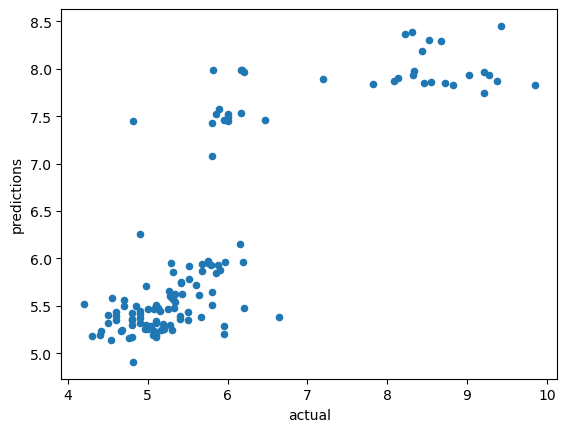

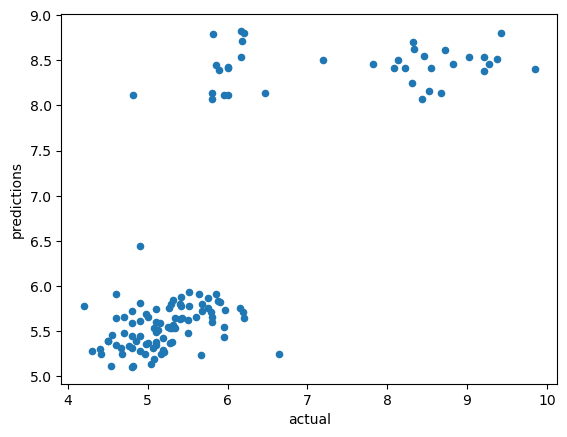

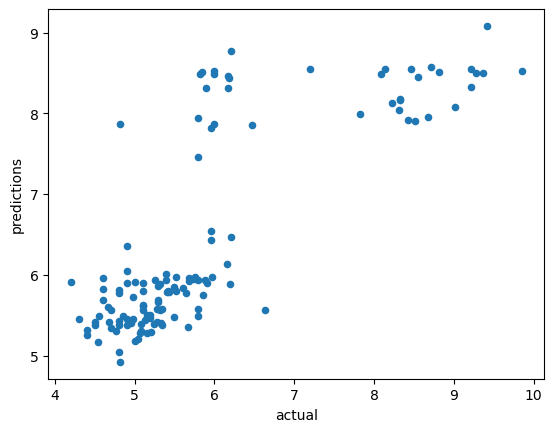

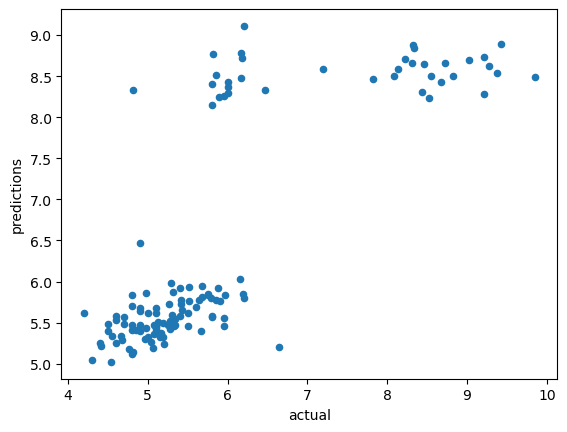

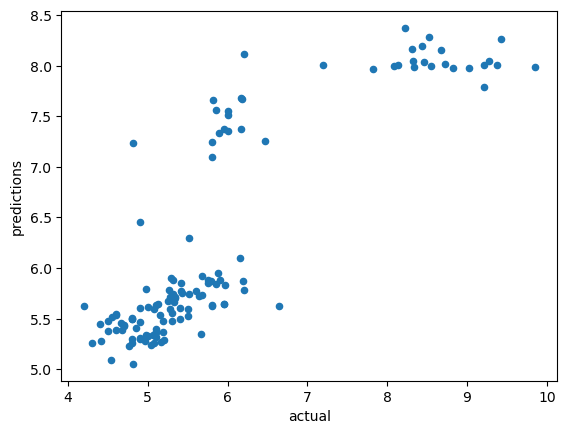

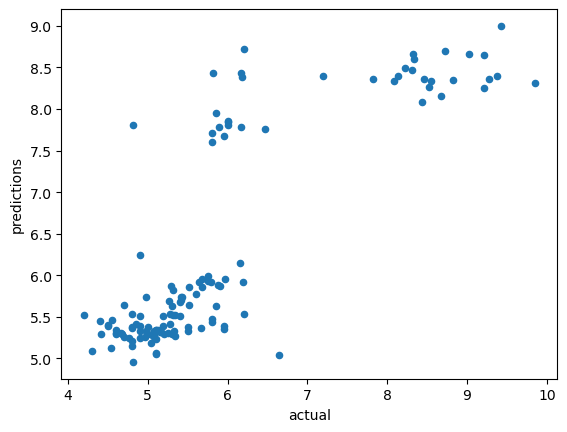

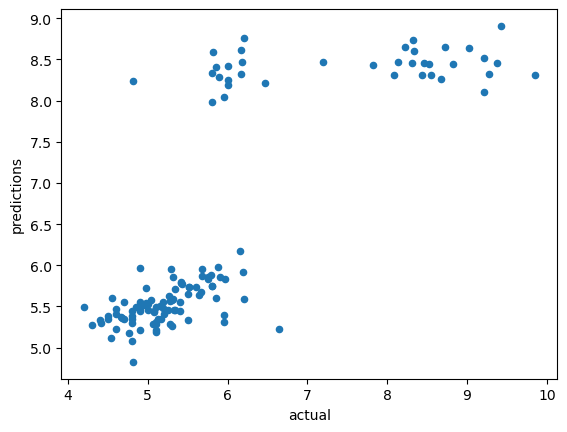

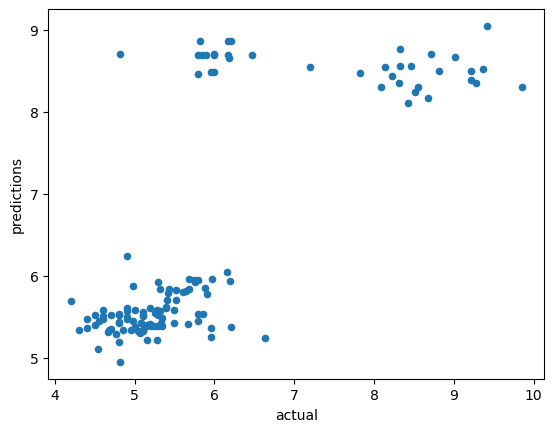

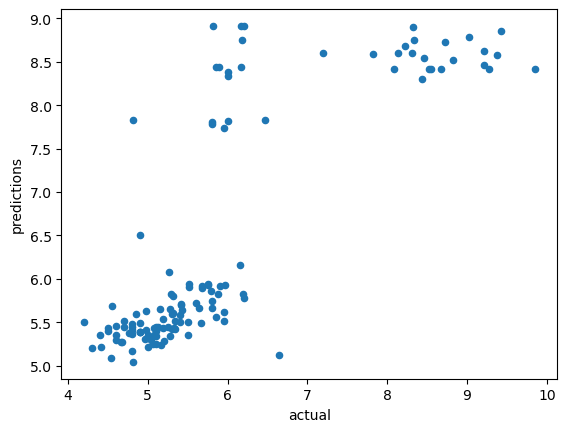

In [29]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_cv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [30]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(9, 3)
(5, 3)
(4, 3)
(6, 3)
(2, 3)
(7, 3)
(5, 3)
(3, 3)
(3, 3)


In [31]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(1, 3)


In [32]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(77, 3)
(77, 3)
(77, 3)
(77, 3)
(77, 3)
(76, 3)
(77, 3)
(77, 3)
(76, 3)


In [33]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(39, 3)
(43, 3)
(44, 3)
(42, 3)
(46, 3)
(41, 3)
(43, 3)
(45, 3)
(45, 3)


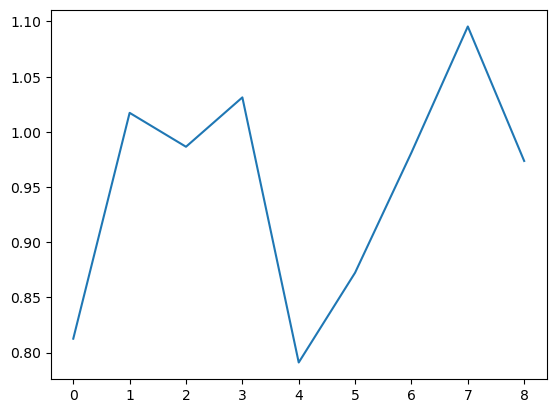

[0.8126169296081116, 1.0172437153936786, 0.9865095891697198, 1.0312444331740076, 0.7910618876919361, 0.8724017399529961, 0.9812641469205658, 1.0954886317174737, 0.9736493753049636]


In [34]:
plt.plot(rmse)
plt.show()
print(rmse)